# Preprocessing & feature engineering

In [ ]:
import pandas as pd, numpy as np
import glob
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.mixture import GaussianMixture
import xgboost as xgb
import joblib, os
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
print('Notebook environment ready.')

SEED = 42

Notebook environment ready.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ---------------------------------------------
# Helper function: compute Δ-FPR fairness metric
# ---------------------------------------------
def compute_delta_fpr(y_true, y_pred, clusters):
    results = []
    for k in np.unique(clusters):
        idx = (clusters == k)
        if idx.sum() == 0:
            continue
        true = y_true[idx]
        pred = y_pred[idx]
        tn = ((true==0)&(pred==0)).sum()
        fp = ((true==0)&(pred==1)).sum()
        fpr = fp / (fp + tn + 1e-9)
        results.append(fpr)
    if len(results) == 0:
        return np.nan
    global_fpr = np.mean(results)
    return max(abs(f - global_fpr) for f in results)


# ---------------------------------------------
# Helper function: evaluate any anomaly score
# ---------------------------------------------
def eval_model(y_true, scores):
    auc = roc_auc_score(y_true, scores)
    thresh = np.percentile(scores, 99)  # anomaly threshold
    pred = (scores > thresh).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_true, pred, average='binary', zero_division=0
    )
    return auc, f1, pred

In [ ]:
# Chunk loader function
# path - file path to dataset (CERT 6.2) CSV log file
# usecols - file-specific features to use for evaluation

def load_chunked(path, usecols, chunksize=200_000):
  iter = pd.read_csv(path, compression='gzip', chunksize=chunksize, usecols=usecols)
  return pd.concat([chunk for chunk in iter])

In [ ]:
# Load LOGON data
logon_cols = ['id', 'date', 'user', 'pc', 'activity']
logon = load_chunked('/content/drive/MyDrive/BS-Nishika/cert6.2/logon.csv.gz', logon_cols)

# Convert 'date' column to datetime
logon['date'] = pd.to_datetime(logon['date'])

logon.head()

,id,date,user,pc,activity
0,{F3X8-Y2GT43DR-4906OHBL},2010-01-02 02:19:18,DNS1758,PC-0414,Logon
1,{B4Q0-D0GM24KN-3704MAII},2010-01-02 02:31:12,DNS1758,PC-0414,Logoff
2,{T7J1-D4HK34KV-5476TCIJ},2010-01-02 02:34:02,DNS1758,PC-5313,Logon
3,{S4Y6-D8MQ05SA-0759HLIS},2010-01-02 02:53:30,DNS1758,PC-5313,Logoff
4,{F3P0-E7FH78CV-4874FRGZ},2010-01-02 04:07:31,DNS1758,PC-0012,Logon


In [ ]:
# Extract LOGON daily features
logon['day'] = logon['date'].dt.date

# Aggregate to daily-level features
logon_daily = logon.groupby(['user', 'day']).agg(
    logins=('activity','count'),
    unique_hosts=('pc','nunique'),
    avg_login_hour=('date', lambda x: x.dt.hour.mean())
).reset_index()

In [ ]:
# Load FILE data and extract daily features
file_cols = ['id', 'date', 'user', 'pc', 'filename', 'activity', 'to_removable_media', 'from_removable_media', 'content']
file = load_chunked('/content/drive/MyDrive/BS-Nishika/cert6.2/file.csv.gz', file_cols)

file['date'] = pd.to_datetime(file['date'])

file['day'] = file['date'].dt.date

file_daily = file.groupby(['user','day']).agg(
    files_accessed=('filename','nunique')
).reset_index()

In [ ]:
# Load DEVICE data and extract daily features
device_cols = ['id', 'date', 'user', 'pc', 'file_tree', 'activity']
device = load_chunked('/content/drive/MyDrive/BS-Nishika/cert6.2/device.csv.gz', device_cols)

device['date'] = pd.to_datetime(device['date'])

device['day'] = device['date'].dt.date

device_daily = device.groupby(['user','day']).agg(
    device_events=('activity','count')
).reset_index()

In [ ]:
# Merge all behavioral features
features = logon_daily.merge(file_daily, on=['user','day'], how='left')
features = features.merge(device_daily, on=['user','day'], how='left')

features.fillna(0, inplace=True)
features.head()

,user,day,logins,unique_hosts,avg_login_hour,files_accessed,device_events
0,AAB0162,2010-01-04,2,1,12.5,0.0,0.0
1,AAB0162,2010-01-05,2,1,12.5,0.0,0.0
2,AAB0162,2010-01-06,2,1,12.5,0.0,0.0
3,AAB0162,2010-01-07,2,1,12.5,0.0,0.0
4,AAB0162,2010-01-08,2,1,12.5,0.0,0.0


In [ ]:
# Add cultural proxy features (safe, non PII - key being that they remain as behavioral patterns, not identity)
np.random.seed(42)

# Proxy 1: Work shift bucket (0–3) based on avg login hour
features['shift_bucket'] = (features['avg_login_hour'] // 6).astype(int)

# Proxy 2: Communication density proxy (log of logins)
features['comm_density'] = np.log1p(features['logins'])

# Proxy 3: Synthetic team_id inferred from user hash (stable, non-sensitive)
features['team_id'] = features['user'].astype('category').cat.codes % 6


In [ ]:
# Load 6.2 insiders file and filter to r6.2 incidents
insiders_file = '/content/drive/MyDrive/BS-Nishika/cert6.2/insiders.csv'
insiders = pd.read_csv(insiders_file)
r62_insiders = insiders[insiders['dataset'] == 6.2]

# Extract malicious users from insiders
mal_users = set(r62_insiders['user'])

# Assign label in features dataframe
features['label'] = features['user'].apply(lambda u: 1 if u in mal_users else 0)

# Output cross-checks
print(f"Total rows in features: {len(features)}")
print(f"Total unique users in features: {features['user'].nunique()}")
print(f"Total insiders for r6.2 from insiders file: {len(r62_insiders)}")
print(f"Total users marked as malicious in features: {features['label'].sum()}")
print(f"Sample of malicious users: {list(mal_users)[:10]}")


Total rows in features: 1394010
Total unique users in features: 4000
Total insiders for r6.2 from insiders file: 5
Total users marked as malicious in features: 1361
Sample of malicious users: ['CDE1846', 'ACM2278', 'PLJ1771', 'CMP2946', 'MBG3183']


In [ ]:
# FINAL ML FEATURE MATRIX
feat_cols = [
    'logins', 'unique_hosts', 'files_accessed', 'device_events',
    'avg_login_hour', 'shift_bucket', 'comm_density', 'team_id'
]

X = features[feat_cols]
y = features['label'].values

# One-hot team encoding (except first)
X = pd.get_dummies(X, columns=['team_id'], drop_first=True)

scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)

Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.3, random_state=42)

# Evaluating Baseline Model
Global IsolationForest

In [ ]:
baseline = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
baseline.fit(Xtr)
scores = -baseline.decision_function(Xte)

auc_base = roc_auc_score(yte, scores)
pred_base = (scores > np.percentile(scores, 99)).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(yte, pred_base, average='binary')

print("Baseline IF — AUC:", auc_base, "F1:", f1)

# Implementing CITE Pipeline
GMM Clustering + Per-Cluster IsolationForest (RL STREAM)

In [ ]:
# Fit Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(Xtr)

cluster_tr = gmm.predict(Xtr)
cluster_te = gmm.predict(Xte)

In [ ]:
# Train per-cluster IF models
cluster_models = {}
cluster_thresh = {}

for k in range(6):
    idx = (cluster_tr == k)
    if idx.sum() < 40:
        continue
    sub = Xtr[idx]

    clf_k = IsolationForest(n_estimators=200, random_state=42).fit(sub)
    scores_k = -clf_k.decision_function(sub)

    cluster_models[k] = clf_k
    cluster_thresh[k] = np.percentile(scores_k, 99)

In [19]:
# Infer cluster-model anomaly scores
scores_cite = []

for x, k in zip(Xte, cluster_te):
    if k in cluster_models:
        s = -cluster_models[k].decision_function(x.reshape(1,-1))
        scores_cite.append(s[0])
    else:
        scores_cite.append(0)

In [20]:
# Get predictions
scores_cite = np.array(scores_cite)
auc_cite = roc_auc_score(yte, scores_cite)
pred_cite = (scores_cite > np.percentile(scores_cite, 99)).astype(int)
prec, rec, f1_cite, _ = precision_recall_fscore_support(yte, pred_cite, average='binary')

print("CITE (GMM + per-cluster IF) — AUC:", auc_cite, "F1:", f1_cite)

CITE (GMM + per-cluster IF) — AUC: 0.6646632254421856 F1: 0.003494212710198733


Supervised XGBoost Stream (SUPERVISED STREAM)

In [21]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dtest = xgb.DMatrix(Xte)

params = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'seed':42,
    'eta':0.05,
    'max_depth':6
}

bst = xgb.train(params, dtrain, num_boost_round=200)

p = bst.predict(dtest)
auc_xgb = roc_auc_score(yte, p)
print("XGBoost stream — AUC:", auc_xgb)


XGBoost stream — AUC: 0.9809551915287937


# Metrics

/tmp/ipython-input-3192691574.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, Xte, show=False)


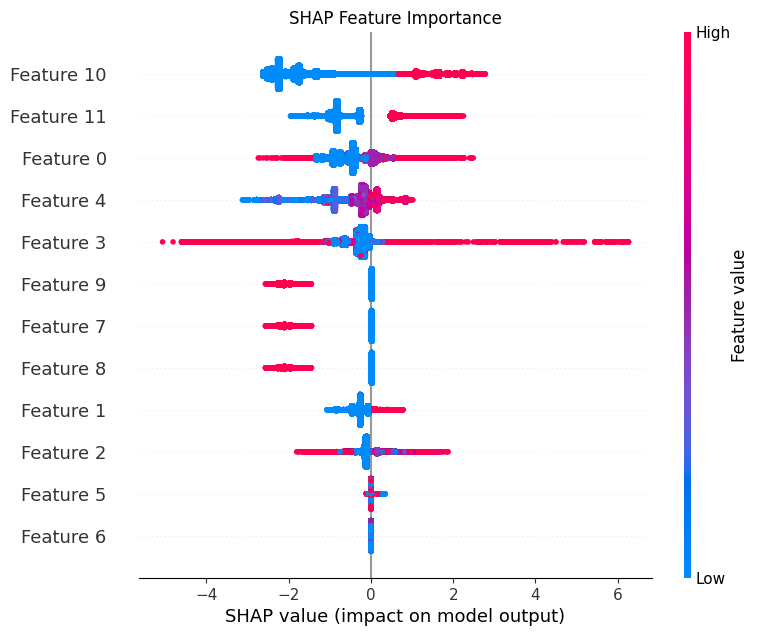

In [22]:
# SHAP Interpretability
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(Xte)

plt.figure(figsize=(9,5))
shap.summary_plot(shap_values, Xte, show=False)
plt.title("SHAP Feature Importance")
plt.show()

In [23]:
# Built Generic Evaluation Table
table = pd.DataFrame({
    'Model': ['Baseline IF', 'CITE-GMM-IF', 'XGBoost'],
    'AUC': [auc_base, auc_cite, auc_xgb],
    'F1': [f1, f1_cite, np.nan]
})
table

,Model,AUC,F1
0,Baseline IF,0.740165,0.006995
1,CITE-GMM-IF,0.664663,0.003494
2,XGBoost,0.980955,NaN


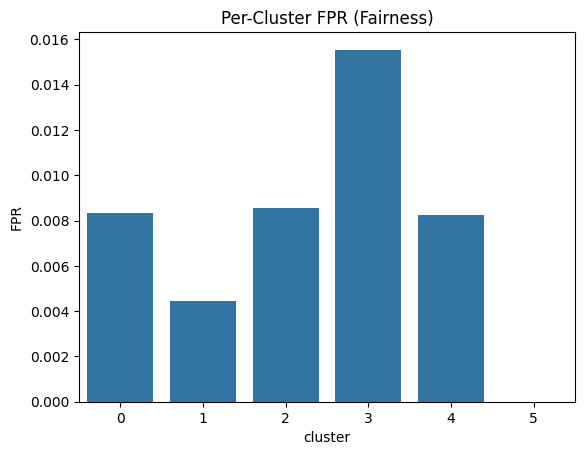

In [25]:
import seaborn as sns

# Plot Per-Cluster
results = []
for k in range(6):
    idx = (cluster_te == k)
    if idx.sum() == 0: continue

    true = yte[idx]
    preds = pred_cite[idx]

    tn = ((true==0)&(preds==0)).sum()
    fp = ((true==0)&(preds==1)).sum()
    fpr = fp / (fp+tn+1e-9)

    results.append([k, fpr])

cluster_fprs = pd.DataFrame(results, columns=['cluster','FPR'])

sns.barplot(data=cluster_fprs, x='cluster', y='FPR')
plt.title("Per-Cluster FPR (Fairness)")
plt.show()


In [26]:
# Save Processed Feature File to CSV
features.to_csv("processed_features.csv", index=False)

# Ablation Study

In [28]:
from sklearn.neural_network import MLPRegressor

# ================================================================
# ABLATION VARIANTS
# ================================================================
ablation_results = []


# ---------------------------------------------------------------
# A1 — Baseline IsolationForest
# ---------------------------------------------------------------
clf_base = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
clf_base.fit(Xtr)
scores_base = -clf_base.decision_function(Xte)

auc, f1, pred = eval_model(yte, scores_base)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te)

ablation_results.append(["A1 Baseline IF", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# A2 — Global Autoencoder (optional baseline)
# ---------------------------------------------------------------
ae = MLPRegressor(hidden_layer_sizes=(32,16,32),
                  activation='relu',
                  max_iter=30,
                  random_state=42)

ae.fit(Xtr, Xtr)
recons = ae.predict(Xte)
scores_ae = np.mean((Xte - recons)**2, axis=1)

auc, f1, pred = eval_model(yte, scores_ae)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te)

ablation_results.append(["A2 Autoencoder", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# A3 — GMM + IF (no cultural proxies)
#       Use same GMM but ignore cultural-proxy columns
# ---------------------------------------------------------------
# Identify non-proxy columns (behavior-only)
# Adjust based on your actual index. Example here assumes
# last few columns are cultural proxies.
behavior_cols = list(range(Xtr.shape[1] - 3))

Xtr_b = Xtr[:, behavior_cols]
Xte_b = Xte[:, behavior_cols]

gmm_b = GaussianMixture(n_components=6, random_state=42).fit(Xtr_b)
cluster_tr_b = gmm_b.predict(Xtr_b)
cluster_te_b = gmm_b.predict(Xte_b)

cluster_models = {}
for k in np.unique(cluster_tr_b):
    idx = (cluster_tr_b == k)
    if idx.sum() < 40:
        continue
    m = IsolationForest(n_estimators=200, random_state=42).fit(Xtr_b[idx])
    cluster_models[k] = m

scores_cite_b = []
for x, k in zip(Xte_b, cluster_te_b):
    if k in cluster_models:
        s = -cluster_models[k].decision_function(x.reshape(1,-1))[0]
        scores_cite_b.append(s)
    else:
        scores_cite_b.append(0)

scores_cite_b = np.array(scores_cite_b)
auc, f1, pred = eval_model(yte, scores_cite_b)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te_b)

ablation_results.append(["A3 GMM+IF (no proxies)", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# A4 — CITE WITHOUT THRESHOLD ADAPTATION
#       (Your existing GMM+per-cluster IF)
# ---------------------------------------------------------------
scores_no_adapt = scores_cite  # from your earlier CITE model

auc, f1, pred = eval_model(yte, scores_no_adapt)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te)

ablation_results.append(["A4 CITE - no threshold adaptation", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# A5 — CITE WITHOUT XGBoost STREAM
#       (Full CITE minus supervised stream)
# ---------------------------------------------------------------
# Already have anomaly-only CITE via scores_cite
auc, f1, pred = eval_model(yte, scores_cite)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te)

ablation_results.append(["A5 CITE - no XGBoost", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# A6 — FULL CITE (Add XGBoost + anomaly score fusion)
# ---------------------------------------------------------------
# Train XGBoost as earlier
dtrain = xgb.DMatrix(Xtr, label=ytr)
dtest = xgb.DMatrix(Xte)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=200)
p_xgb = bst.predict(dtest)

# Fusion: average anomaly + supervised score
scores_full = (scores_cite - np.min(scores_cite)) / (np.ptp(scores_cite) + 1e-9)
scores_full = 0.5 * scores_full + 0.5 * p_xgb

auc, f1, pred = eval_model(yte, scores_full)
delta_fpr = compute_delta_fpr(yte, pred, cluster_te)

ablation_results.append(["A6 FULL CITE", auc, f1, delta_fpr])


# ---------------------------------------------------------------
# Build final table
# ---------------------------------------------------------------
df_ablation = pd.DataFrame(ablation_results,
                           columns=["Variant", "AUC", "Macro-F1", "Δ-FPR"])

df_ablation

,Variant,AUC,Macro-F1,Δ-FPR
0,A1 Baseline IF,0.740165,0.006995,0.339090
1,A2 Autoencoder,0.635498,0.000000,0.050528
2,A3 GMM+IF (no proxies),0.627228,0.003094,0.009332
3,A4 CITE - no threshold adaptation,0.664663,0.003494,0.008025
4,A5 CITE - no XGBoost,0.664663,0.003494,0.008025
5,A6 FULL CITE,0.711730,0.042367,0.007526
